# Imports

In [93]:
import numpy as np
import pandas as pd
import json
import datetime

import re
import nltk
from nltk.corpus import stopwords

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read Categories Json and Trending Data for US

In [95]:
categories_df = pd.read_json('/content/drive/Shared drives/Google3F_AI_Studio/US_category_id.json')
categories_df = pd.json_normalize(categories_df['items'])[['id', 'snippet.title']]
categories_df = categories_df.rename(columns={'snippet.title': 'title'})

In [96]:
categories_df.head(30)

,id,title
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports
5,18,Short Movies
6,19,Travel & Events
7,20,Gaming
8,21,Videoblogging
9,22,People & Blogs


In [97]:
data_df = pd.read_csv('/content/drive/Shared drives/Google3F_AI_Studio/US_youtube_trending_data.csv')
data_df['publishedAt'] = pd.to_datetime(data_df['publishedAt'], dayfirst=True, format='ISO8601', utc=True)
data_df['trending_date'] = pd.to_datetime(data_df['trending_date'], dayfirst=True, format='ISO8601', utc=True)

# Add a day of the week column
data_df.loc[:, 'published_day_of_week'] = data_df['publishedAt'].dt.day_name()
data_df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,published_day_of_week
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12 00:00:00+00:00,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,Tuesday
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12 00:00:00+00:00,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",Tuesday
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12 00:00:00+00:00,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,Tuesday
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12 00:00:00+00:00,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,Tuesday
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12 00:00:00+00:00,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,Tuesday


Merge the categories_df into the data_df to add a CategoryName to go with the categoryId so it's more interpretable.

In [98]:

# Convert 'categoryId' in data_df to string type so a join can be performed
data_df['categoryId'] = data_df['categoryId'].astype(str)
data_df = pd.merge(data_df, categories_df, left_on='categoryId', right_on='id', how='left')
data_df = data_df.rename(columns={'title_x': 'title', 'title_y': 'categoryName'})
# Rearrange columns to place 'categoryName' after 'categoryId'
data_df = data_df[['video_id','title', 'publishedAt', 'published_day_of_week', 'channelId', 'channelTitle',
                   'categoryId', 'categoryName', 'trending_date', 'tags', 'view_count',
                   'likes', 'dislikes', 'comment_count','description']]

In [99]:
data_df.head()

,video_id,title,publishedAt,published_day_of_week,channelId,channelTitle,categoryId,categoryName,trending_date,tags,view_count,likes,dislikes,comment_count,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,Tuesday,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,People & Blogs,2020-08-12 00:00:00+00:00,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,Tuesday,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,Gaming,2020-08-12 00:00:00+00:00,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,Tuesday,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,Entertainment,2020-08-12 00:00:00+00:00,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,Tuesday,UCbg_UMjlHJg_19SZckaKajg,XXL,10,Music,2020-08-12 00:00:00+00:00,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,Tuesday,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,Howto & Style,2020-08-12 00:00:00+00:00,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,Transforming The LaBrant Family's empty white ...


In [100]:
# prompt: Create a table with the number of unique values for each column

unique_counts = data_df.nunique()
unique_counts_table = pd.DataFrame({'Column': unique_counts.index, 'Unique Values': unique_counts.values})
print(unique_counts_table)


                   Column  Unique Values
0                video_id          47142
1                   title          48471
2             publishedAt          46554
3   published_day_of_week              7
4               channelId           8302
5            channelTitle           8543
6              categoryId             15
7            categoryName             15
8           trending_date           1323
9                    tags          32909
10             view_count         255236
11                  likes         136839
12               dislikes          13179
13          comment_count          35557
14            description          48448


In [101]:
print(data_df.shape)
# print("2020:",df_2020.shape)
# print("2021:",df_2021.shape)
# print("2022:",df_2022.shape)
# print("2023:",df_2023.shape)
# print("2024:",df_2024.shape)

(268787, 15)


In [102]:
data_df.columns

Index(['video_id', 'title', 'publishedAt', 'published_day_of_week',
       'channelId', 'channelTitle', 'categoryId', 'categoryName',
       'trending_date', 'tags', 'view_count', 'likes', 'dislikes',
       'comment_count', 'description'],
      dtype='object')

In [103]:
data_df['log_view_count'] = np.log(data_df['view_count'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# New Features

## days_since_published

In [104]:
# Cut the times in publishedAt and only keep the dates
data_df['publishedAt_date'] = pd.to_datetime(data_df['publishedAt']).dt.date

# Cut the times in trending_date and only keep the dates
data_df['trending_date'] = pd.to_datetime(data_df['trending_date']).dt.date

# Recompute days since published
# Calculate days since published for each row
data_df['days_since_published'] = (pd.to_datetime(data_df['trending_date']) - pd.to_datetime(data_df['publishedAt_date'])).dt.days + 1

# Apply a lambda function to take the 'days_since_published' at lowest 1
data_df['days_since_published'] = data_df['days_since_published'].apply(lambda x: max(x, 1))

In [105]:
# prompt: create a column named square_of_days_since_published and log_days_since_publication

data_df['square_of_days_since_published'] = data_df['days_since_published'] ** 2
data_df['log_days_since_publication'] = np.log(data_df['days_since_published'])
data_df['sqrt_days_since_publication'] = np.sqrt(data_df['days_since_published'])



## View Velocity

In [106]:
# Edit: Taking log of view count before dividing by days
data_df['log_view_velocity'] = np.log(data_df['view_count'] +1)/ (data_df['days_since_published'])


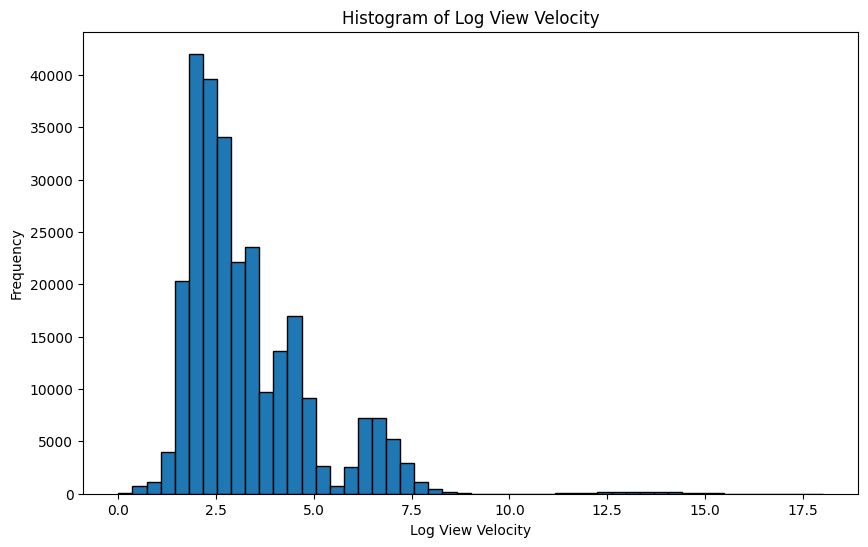

In [107]:
# histogram for log view velocity

plt.figure(figsize=(10, 6))
plt.hist(data_df['log_view_velocity'], bins=50, edgecolor='black')
plt.xlabel('Log View Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Log View Velocity')
plt.show()

## Length of title

In [108]:
# prompt: generate a column for the length of the title, and a column for number of tags

data_df['title_length'] = data_df['title'].str.len()
data_df['tags_count'] = data_df['tags'].str.split('|').str.len()

data_df['description_length'] = data_df['description'].str.len()

## Top tags count

In [109]:
#Split the tags column into a list of tags
data_df['tags_list'] = data_df['tags'].str.split('|')

#Flatten the list of tags into a single list
all_tags = [tag for tags in data_df['tags_list'] for tag in tags]

##Count the frequency of each tag
tag_counts = Counter(all_tags)

#Get the top twenty tags
top_twenty_tags = [tag for tag, count in tag_counts.most_common(20)]

#Count how many of the top 20 tags are present in each row and sum them
data_df['top_20_tag_count'] = data_df['tags_list'].apply(lambda tags: sum(1 for tag in tags if tag in top_twenty_tags))

# Feature Engineering

## One Hot Encoding

In [110]:
# prompt: use onehotencoder to do the encoding instead for weekdays, categoryName

# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore', drop = 'first')

# Fit and transform the 'categoryName' column
encoded_category = enc.fit_transform(data_df[['categoryName']]).toarray()

# Create a new DataFrame with the encoded features
encoded_category_df = pd.DataFrame(encoded_category, columns=['category_' + str(i) for i in range(encoded_category.shape[1])])

# Concatenate the encoded DataFrame with the original DataFrame
data_df = pd.concat([data_df, encoded_category_df], axis=1)

# Drop the original 'categoryName' column
data_df = data_df.drop('categoryName', axis=1)



# Fit and transform the 'published_day_of_week' column
encoded_weekday = enc.fit_transform(data_df[['published_day_of_week']]).toarray()

# Create a new DataFrame with the encoded features
encoded_weekday_df = pd.DataFrame(encoded_weekday, columns=['weekday_' + str(i) for i in range(encoded_weekday.shape[1])])

# Concatenate the encoded DataFrame with the original DataFrame
data_df = pd.concat([data_df, encoded_weekday_df], axis=1)

# Drop the original 'published_day_of_week' column
data_df = data_df.drop('published_day_of_week', axis=1)

In [111]:
#one hot encoding for channels

from sklearn.feature_extraction import FeatureHasher

# Assuming 'channelId' is the column you want to encode
channel_ids = data_df['channelId'].values.astype(str)

# Initialize the FeatureHasher with a fixed number of features (e.g., 100)
hasher = FeatureHasher(n_features=2**8, input_type='string')

# Reshape channel_ids into a 2D array where each row is a sample
channel_ids = channel_ids.reshape(-1, 1)

# Fit and transform the channel IDs to create hashed features
hashed_features = hasher.fit_transform(channel_ids)

# Convert the hashed features to a dense array (optional)
hashed_features_array = hashed_features.toarray()

# Create a DataFrame with the hashed features
hashed_features_df = pd.DataFrame(hashed_features_array, columns=[f'channelId_hash_{i}' for i in range(hashed_features_array.shape[1])])

# Concatenate the hashed features DataFrame with your original DataFrame
data_df = pd.concat([data_df, hashed_features_df], axis=1)

In [112]:
#One hot encoding for top 100 channels
# Step 1: Get top 100 channel IDs
top_100_channel_ids = data_df['channelId'].value_counts().nlargest(100).index

# Step 2: Create a new column for 'Other' channels not in the top 100
data_df['channelCategory'] = data_df['channelId'].apply(lambda x: x if x in top_100_channel_ids else 'Other')

# Step 3: Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Step 4: Fit and transform the channel categories
encoded_channels = encoder.fit_transform(data_df[['channelCategory']])

# Step 5: Create a DataFrame for the encoded channel data
encoded_channels_df = pd.DataFrame(
    encoded_channels,
    columns=[f'channel_{cat}' for cat in encoder.categories_[0]],  # create appropriate column names
    index=data_df.index
)

# Step 6: Concatenate the original dataframe with the encoded channel data
data_df = pd.concat([data_df, encoded_channels_df], axis=1)


In [113]:
data_df.columns

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       ...
       'channel_UCtylTUUVIGY_i5afsQYeBZA', 'channel_UCurvRE5fGcdUgCYWgh-BDsg',
       'channel_UCvC4D8onUfXzvjTOM-dBfEA', 'channel_UCvK4bOhULCpmLabd2pDMtnA',
       'channel_UCvgfXK4nTYKudb0rFR6noLA', 'channel_UCw1SQ6QRRtfAhrN_cjkrOgA',
       'channel_UCwIWAbIeu0xI0ReKWOcw3eg', 'channel_UCx-KWLTKlB83hDI6UKECtJQ',
       'channel_UCz97F7dMxBNOfGYu3rx8aCw', 'channel_UCzTlXb7ivVzuFlugVCv3Kvg'],
      dtype='object', length=403)

In [114]:
data_df.shape

(268787, 403)

In [115]:
data_df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,channel_UCtylTUUVIGY_i5afsQYeBZA,channel_UCurvRE5fGcdUgCYWgh-BDsg,channel_UCvC4D8onUfXzvjTOM-dBfEA,channel_UCvK4bOhULCpmLabd2pDMtnA,channel_UCvgfXK4nTYKudb0rFR6noLA,channel_UCw1SQ6QRRtfAhrN_cjkrOgA,channel_UCwIWAbIeu0xI0ReKWOcw3eg,channel_UCx-KWLTKlB83hDI6UKECtJQ,channel_UCz97F7dMxBNOfGYu3rx8aCw,channel_UCzTlXb7ivVzuFlugVCv3Kvg
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
data_df.columns[:30]

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       'dislikes', 'comment_count', 'description', 'log_view_count',
       'publishedAt_date', 'days_since_published',
       'square_of_days_since_published', 'log_days_since_publication',
       'sqrt_days_since_publication', 'log_view_velocity', 'title_length',
       'tags_count', 'description_length', 'tags_list', 'top_20_tag_count',
       'category_0', 'category_1', 'category_2', 'category_3', 'category_4'],
      dtype='object')

## Normalize numerical columns

In [117]:
# prompt: normalize the columns without negative numbers.

from sklearn.preprocessing import MinMaxScaler

# Select numerical columns
#numerical_cols = ['log_view_count','view_velocity','l_channel_total_views','l_channel_avg_views',
#                  'days_since_published', 'engagement_rate','top_20_tag_count']
numerical_cols = ['days_since_published', 'square_of_days_since_published', 'sqrt_days_since_publication'
                  , 'log_days_since_publication', 'title_length', 'tags_count', 'description_length']


# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Replace infinite values with NaN
data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fit and transform the numerical columns
data_df[numerical_cols] = scaler.fit_transform(data_df[numerical_cols])


## Replace Missing Data

In [118]:
# prompt: create a dataframe from features list with days_since_publication, square_of_days_since_published, log_days_since_published, all top 100 channels dummies,
# top 15 categories,
# day of the week published

features = ['days_since_published', 'square_of_days_since_published',
            'log_days_since_publication', 'sqrt_days_since_publication',
            'title_length', 'tags_count','description_length','top_20_tag_count']


model_df = data_df[features]

# Add day of the week published, category, channel dummies
model_df = model_df.join(encoded_weekday_df)
model_df = model_df.join(encoded_category_df)
model_df = model_df.join(encoded_channels_df)
model_df = model_df.join(hashed_features_df)


# add col names to features list
features += list(encoded_weekday_df.columns) + list(encoded_category_df.columns) + list(encoded_channels_df.columns) + list(hashed_features_df.columns)




In [119]:
# prompt: add the columns l_view_velocity and trending_data onto model_data

model_df['log_view_velocity'] = data_df['log_view_velocity']
model_df['trending_date'] = data_df['trending_date']


In [120]:
model_df.isnull().values.any()

True

In [121]:
nan_count = np.sum(model_df.isnull(), axis = 0)
nan_count.sort_values(ascending=False)

,0
description_length,4549
days_since_published,0
channelId_hash_125,0
channelId_hash_135,0
channelId_hash_134,0
...,...
channel_UCz97F7dMxBNOfGYu3rx8aCw,0
channel_UCx-KWLTKlB83hDI6UKECtJQ,0
channel_UCwIWAbIeu0xI0ReKWOcw3eg,0
channel_UCw1SQ6QRRtfAhrN_cjkrOgA,0


In [122]:
model_df['description_length'].fillna(0, inplace=True)



<ipython-input-122-488f08f28888>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_df['description_length'].fillna(0, inplace=True)


In [123]:
model_df.isnull().values.any()

False

In [124]:
model_df['days_since_published']

,days_since_published
0,0.027027
1,0.027027
2,0.027027
3,0.027027
4,0.027027
...,...
268782,0.189189
268783,0.297297
268784,0.216216
268785,0.216216


# Model Training

## Plot functions

In [125]:

import matplotlib.pyplot as plt

def plot_y_pred_test(model):
  y_pred = model.predict(X_test)

  plt.figure(figsize=(8, 8))
  plt.scatter(y_test, y_pred)
  plt.xlabel("Actual Log View Velocity")
  plt.ylabel("Predicted Log View Velocity")
  plt.title("Scatter Plot of Predictions vs. Actual Values")

  # Add a diagonal line representing perfect predictions
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

  # Ensure axes are proportional
  plt.gca().set_aspect('equal', adjustable='box')

  plt.show()


def plot_log_views(model):
# Make predictions on the test set
  y_pred = model.predict(X_test)
  y_pred = pd.DataFrame(y_pred)

  # Multiply predictions by 'days_since_published' for respective rows in model_df
  predicted_multiplied = y_pred * model_df.loc[X_test.index, 'days_since_published'].values.reshape(-1, 1)

  # Multiply actual values (y_test) by 'days_since_published' for the respective rows in model_df
  actual_multiplied = y_test * model_df.loc[y_test.index, 'days_since_published']

  # Plot predicted vs actual values
  plt.figure(figsize=(8, 6))
  plt.scatter(actual_multiplied, predicted_multiplied)
  plt.xlabel("Actual Log Views")
  plt.ylabel("Predicted Log Views")
  plt.title("Predicted vs. Actual Log Views (Multiplied by Days Since Published)")

  # Add a diagonal line for reference (perfect predictions)
  plt.plot([actual_multiplied.min(), actual_multiplied.max()], [actual_multiplied.min(), actual_multiplied.max()], 'k--', lw=2)

  # Show the plot
  plt.show()

def plot_learning_curve():
  plt.plot(history.history['mse'], label='train mse')
  plt.plot(history.history['val_mse'], label='val mse')
  plt.title('Learning Curve')
  plt.ylabel('MSE')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

## Train val test split

In [126]:
import tensorflow.keras as keras
from datetime import date
import time

## Model with added numerical and categorical features

In [128]:

# Assuming you have already loaded and preprocessed your data as in the provided code
# and model_df is your DataFrame with 'trending_date' and 'log_view_velocity'
features = ['days_since_published', 'square_of_days_since_published',
            'log_days_since_publication', 'sqrt_days_since_publication']
features += list(encoded_weekday_df.columns) + list(encoded_category_df.columns) + list(encoded_channels_df.columns)

# Convert 'trending_date' to datetime objects if it's not already
model_df['trending_date'] = pd.to_datetime(model_df['trending_date'])

# Define the split dates
train_end_date = pd.to_datetime('2023-12-31')
validation_end_date = pd.to_datetime('2024-02-18')

# Create train, validation, and test datasets
train_df = model_df[(model_df['trending_date'] <= train_end_date)]
validation_df = model_df[(model_df['trending_date'] > train_end_date) & (model_df['trending_date'] <= validation_end_date)]
test_df = model_df[(model_df['trending_date'] > validation_end_date)]

# Separate features and target variable for train, validation, and test sets
X_train = train_df[features]
y_train = train_df['log_view_velocity']
X_validation = validation_df[features]
y_validation = validation_df['log_view_velocity']
X_test = test_df[features]
y_test = test_df['log_view_velocity']

# Now you have your train, validation, and test sets ready for model training and evaluation.

In [ ]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import layers


# Define the model
model = keras.Sequential([
    keras.layers.Dense(256, activation='tanh', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(16, activation='tanh'),
    keras.layers.Dense(1)
])
# Adjust learning rate
learning_rate = 0.00001  # You can experiment with different values

# Compile the model with adjusted learning rate
optimizer = AdamW(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_validation, y_validation))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - loss: 3.3498 - mse: 3.3498 - val_loss: 0.2513 - val_mse: 0.2513
Epoch 2/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - loss: 0.4607 - mse: 0.4607 - val_loss: 0.0814 - val_mse: 0.0814
Epoch 3/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 0.2845 - mse: 0.2845 - val_loss: 0.0728 - val_mse: 0.0728
Epoch 4/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 0.2355 - mse: 0.2355 - val_loss: 0.0680 - val_mse: 0.0680
Epoch 5/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - loss: 0.2114 - mse: 0.2114 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 6/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 0.1804 - mse: 0.1804 - val_loss: 0.0621 - val_mse: 0.0621
Epoch 7/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 0.1521 - mse: 0.1521 - val_loss: 0.0588 - val_mse: 0.0588
Epoch 8/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 0.1343 - mse: 0.1343 - val_loss: 0.0558 - val_mse: 0.0558
Epoch 9/20
15475

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


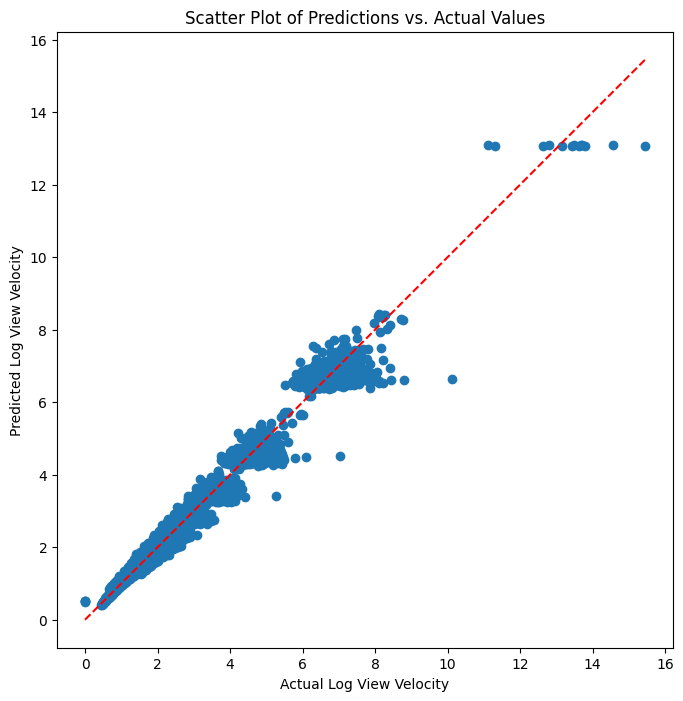

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


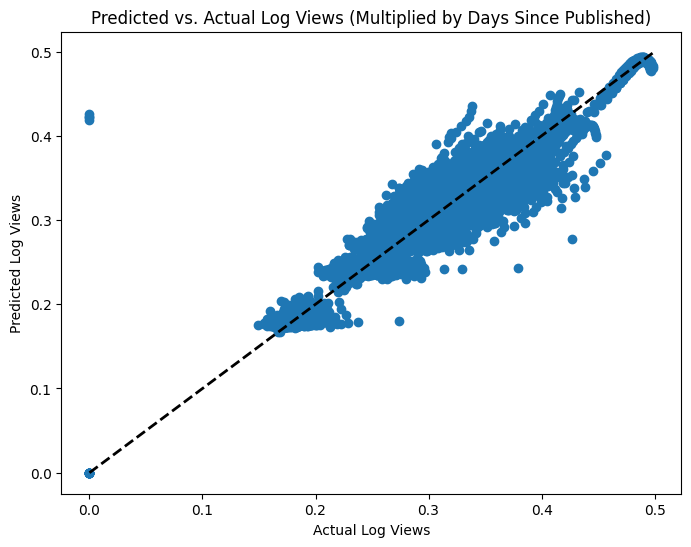

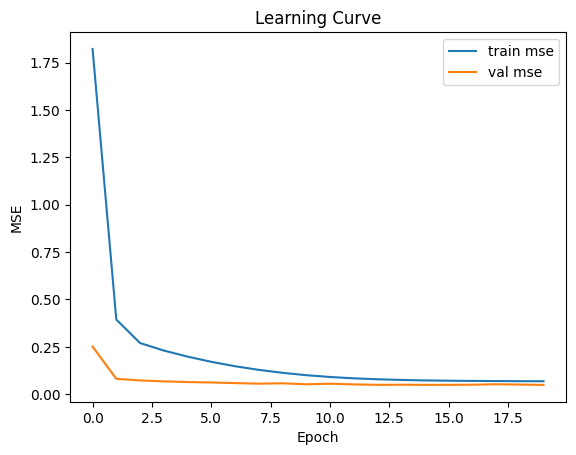

In [ ]:

# Call the plot functions
plot_y_pred_test(model)
plot_log_views(model)
plot_learning_curve()

In [ ]:
# prompt: get test mse

mse = model.evaluate(X_test, y_test)[1]
print(f"Test MSE: {mse}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0447 - mse: 0.0447
Test MSE: 0.046323858201503754


In [ ]:
history.history['val_mse'][-1]

0.049171097576618195

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Sequential

# Define the model
model = Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer
])

# Adjust learning rate
learning_rate = 0.00001  # Experiment with slightly lower rates if needed
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_validation, y_validation))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 6.0257 - mse: 6.0257 - val_loss: 0.3518 - val_mse: 0.3518
Epoch 2/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.3846 - mse: 0.3846 - val_loss: 0.1073 - val_mse: 0.1073
Epoch 3/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.1448 - mse: 0.1448 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 4/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 0.0992 - mse: 0.0992 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 5/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.0812 - mse: 0.0812 - val_loss: 0.0578 - val_mse: 0.0578
Epoch 6/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.0549 - val_mse: 0.0549
Epoch 7/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 8/20
15475/15475 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.0715 - mse: 0.0715 - val_loss: 0.0528 - val_mse: 0.0528
Epoch 9/20
15475

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


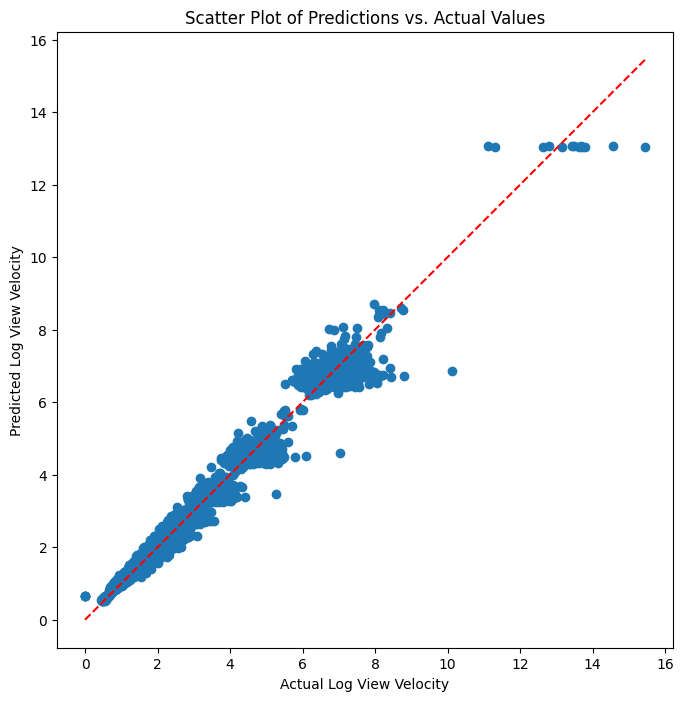

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


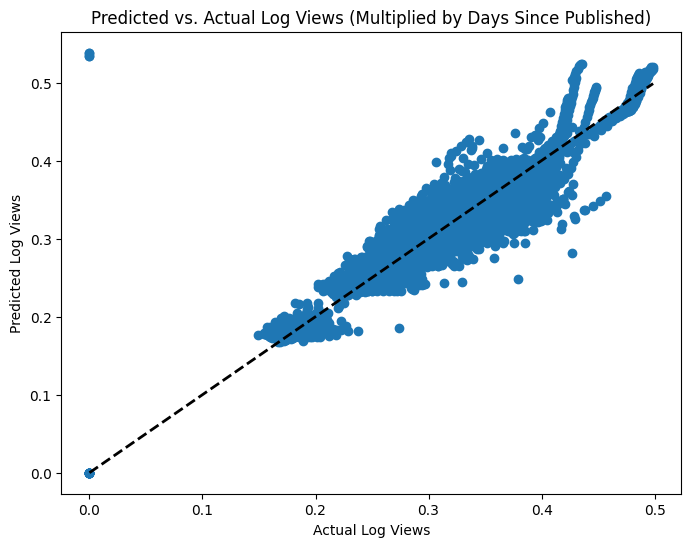

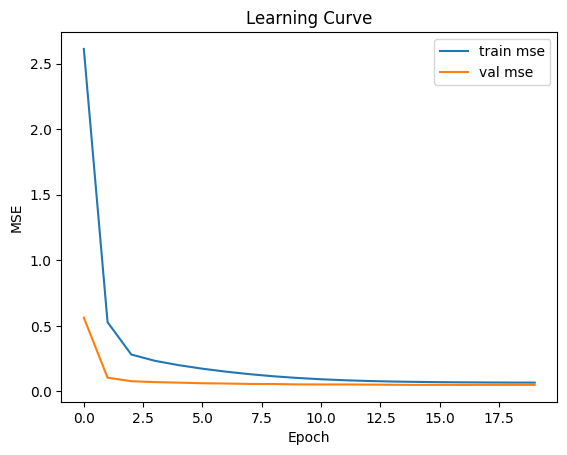

In [ ]:

# Call the plot functions
plot_y_pred_test(model)
plot_log_views(model)
plot_learning_curve()

In [ ]:
mse = model.evaluate(X_test, y_test)[1]
print(f"Test MSE: {mse}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0452 - mse: 0.0452
Test MSE: 0.045772481709718704


In [ ]:
history.history['val_mse'][-2]

0.05014915019273758

# Current Model *

In [ ]:
# same model just using adam optimizer

from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import BatchNormalization


model = keras.Sequential([
    keras.layers.Dense(128, activation='tanh', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1)
])
adam = Adam(learning_rate=0.00001)
# Compile the model with adjusted learning rate

model.compile(optimizer= adam, loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=42, validation_data=(X_validation, y_validation))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 6.4083 - mse: 6.4083 - val_loss: 1.2840 - val_mse: 1.2840
Epoch 2/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.2352 - mse: 1.2352 - val_loss: 0.3742 - val_mse: 0.3742
Epoch 3/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.4330 - mse: 0.4330 - val_loss: 0.1010 - val_mse: 0.1010
Epoch 4/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.2010 - mse: 0.2010 - val_loss: 0.0819 - val_mse: 0.0819
Epoch 5/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.1599 - mse: 0.1599 - val_loss: 0.0699 - val_mse: 0.0699
Epoch 6/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.1343 - mse: 0.1343 - val_loss: 0.0624 - val_mse: 0.0624
Epoch 7/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1176 - mse: 0.1176 - val_loss: 0.0596 - val_mse: 0.0596
Epoch 8/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1005 - mse: 0.1005 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 9/20
5895/5895 ━━━━━━━━━━━

In [ ]:


# Access and print MSE and validation MSE with more digits
last_epoch_mse = history.history['mse'][-1]
last_epoch_val_mse = history.history['val_mse'][-1]
print(f"MSE of the last epoch: {last_epoch_mse:.10f}")
print(f"Validation MSE of the last epoch: {last_epoch_val_mse:.10f}")

# ... (Rest of your code)

MSE of the last epoch: 0.0694079399
Validation MSE of the last epoch: 0.0498483740


In [ ]:
history.history['val_mse'][-1]

0.04984837397933006

In [ ]:
# prompt: get test mse

mse = model.evaluate(X_test, y_test)[1]
print(f"Test MSE: {mse}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0443 - mse: 0.0443
Test MSE: 0.04648539051413536


357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


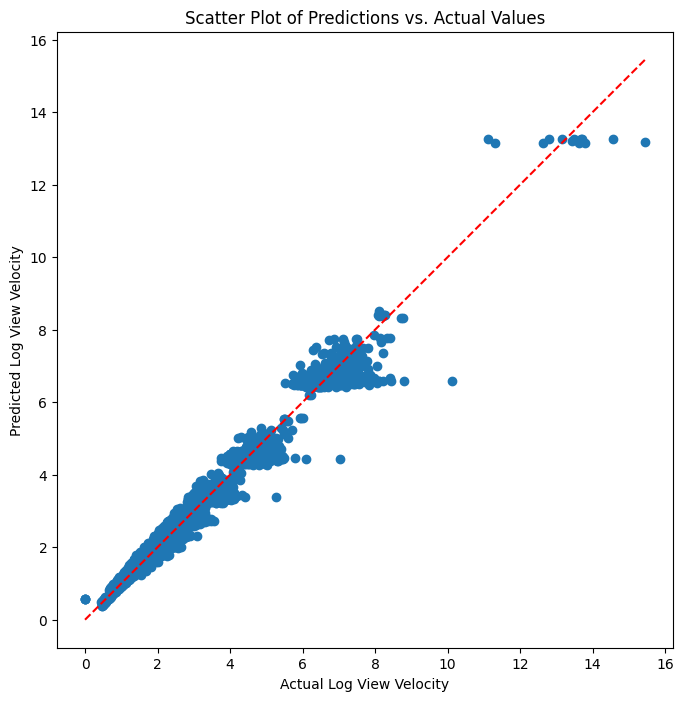

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


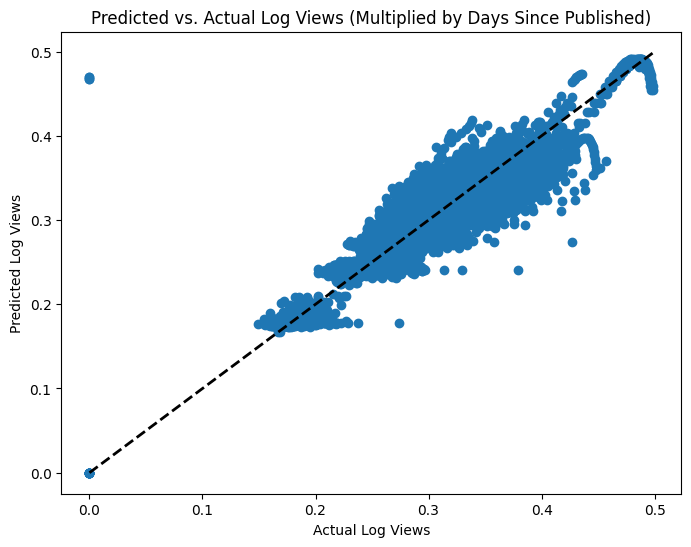

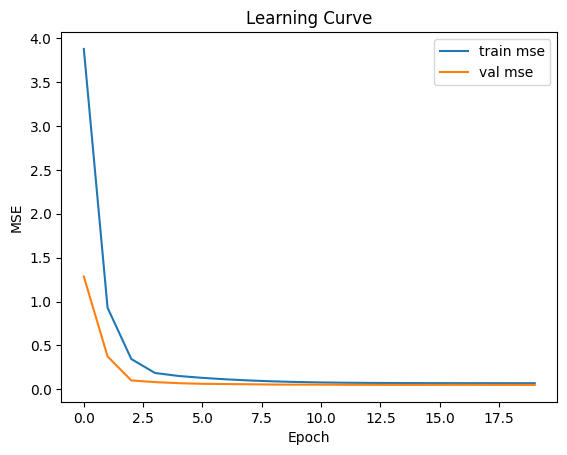

In [ ]:
# prompt: apply my three plot functions

# Assuming you have already trained your model and have X_test and y_test defined

# Call the plot functions
plot_y_pred_test(model)
plot_log_views(model)
plot_learning_curve()

In [ ]:
# same model just using adam optimizer

from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import BatchNormalization


model = keras.Sequential([
    keras.layers.Dense(128, activation='tanh', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1)
])
adam = Adam(learning_rate=0.00001)
# Compile the model with adjusted learning rate

model.compile(optimizer= adam, loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=42, validation_data=(X_validation, y_validation))

## Another try using adam Relu


In [ ]:
# same model just using adam optimizer

from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import BatchNormalization


model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])
adam = Adam(learning_rate=0.00001)
# Compile the model with adjusted learning rate

model.compile(optimizer= adam, loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_validation, y_validation))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 7.0158 - mse: 7.0158 - val_loss: 1.3475 - val_mse: 1.3475
Epoch 2/30
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1.1494 - mse: 1.1494 - val_loss: 0.2643 - val_mse: 0.2643
Epoch 3/30
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.3008 - mse: 0.3008 - val_loss: 0.1065 - val_mse: 0.1065
Epoch 4/30
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.1436 - mse: 0.1436 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 5/30
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.1091 - mse: 0.1091 - val_loss: 0.0689 - val_mse: 0.0689
Epoch 6/30
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0903 - mse: 0.0903 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 7/30
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0806 - mse: 0.0806 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 8/30
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0760 - mse: 0.0760 - val_loss: 0.0555 - val_mse: 0.0555
Epoch 9/30
7738/7738 ━━━━━━━━━━━

In [ ]:
# prompt: get test mse

mse = model.evaluate(X_test, y_test)[1]
print(f"Test MSE: {mse}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0459 - mse: 0.0459
Test MSE: 0.04760228097438812


357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


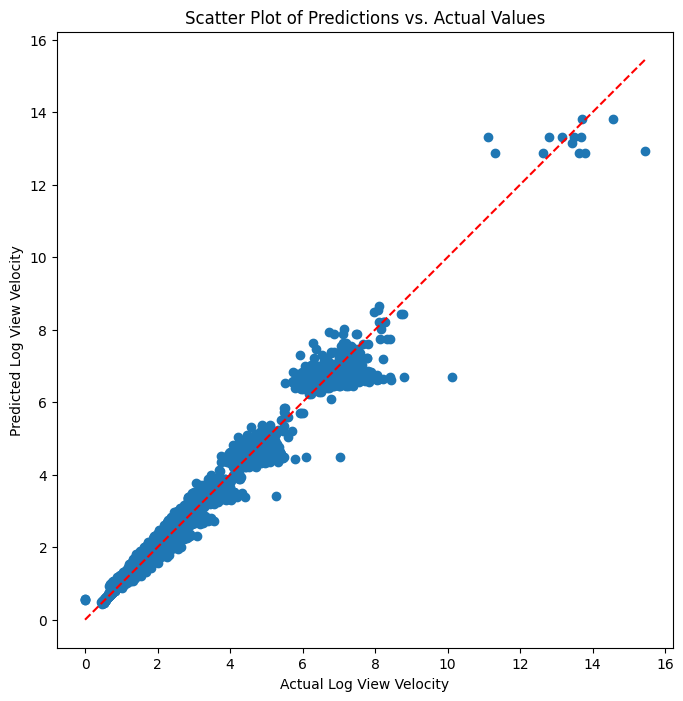

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


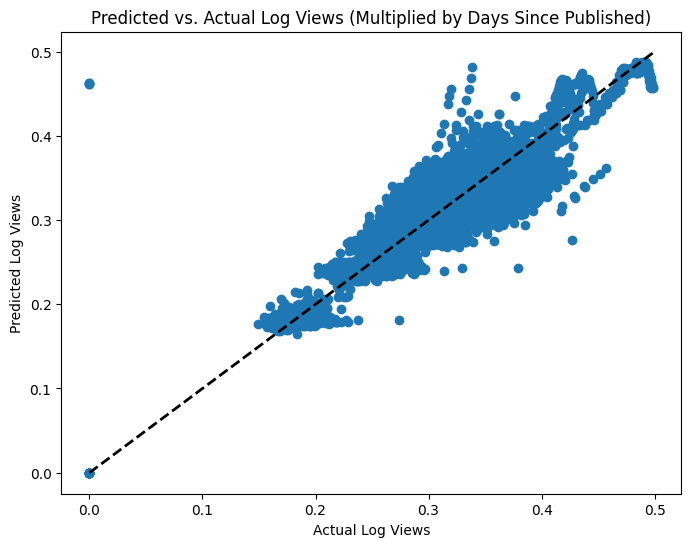

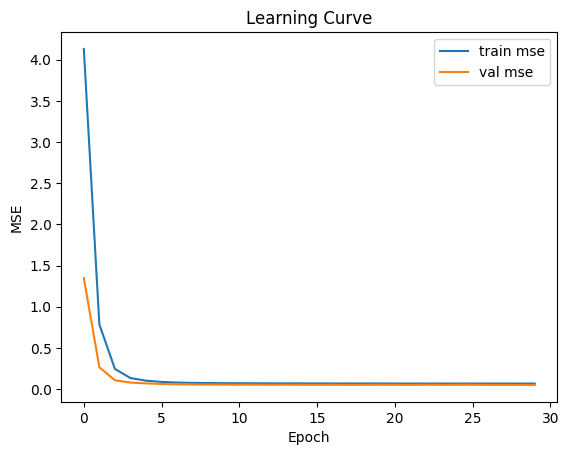

In [ ]:
# Assuming you have already trained your model and have X_test and y_test defined

# Call the plot functions
plot_y_pred_test(model)
plot_log_views(model)
plot_learning_curve()

In [130]:
from tensorflow.keras.optimizers import Adam


model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

adam = Adam(learning_rate=0.00001)
model.compile(optimizer= adam, loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=42, validation_data=(X_validation, y_validation))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 5.9492 - mse: 5.9492 - val_loss: 0.3088 - val_mse: 0.3088
Epoch 2/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.3303 - mse: 0.3303 - val_loss: 0.0911 - val_mse: 0.0911
Epoch 3/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.1175 - mse: 0.1175 - val_loss: 0.0671 - val_mse: 0.0671
Epoch 4/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0864 - mse: 0.0864 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 5/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0748 - mse: 0.0748 - val_loss: 0.0547 - val_mse: 0.0547
Epoch 6/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0719 - mse: 0.0719 - val_loss: 0.0525 - val_mse: 0.0525
Epoch 7/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0690 - mse: 0.0690 - val_loss: 0.0518 - val_mse: 0.0518
Epoch 8/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0693 - mse: 0.0693 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 9/20
5895/5895 ━━━━━━━━━━━

In [131]:
# prompt: get test mse

mse = model.evaluate(X_test, y_test)[1]
print(f"Test MSE: {mse}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0466 - mse: 0.0466
Test MSE: 0.0481569841504097


In [132]:
history.history['val_mse'][-1]

0.05188659578561783

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


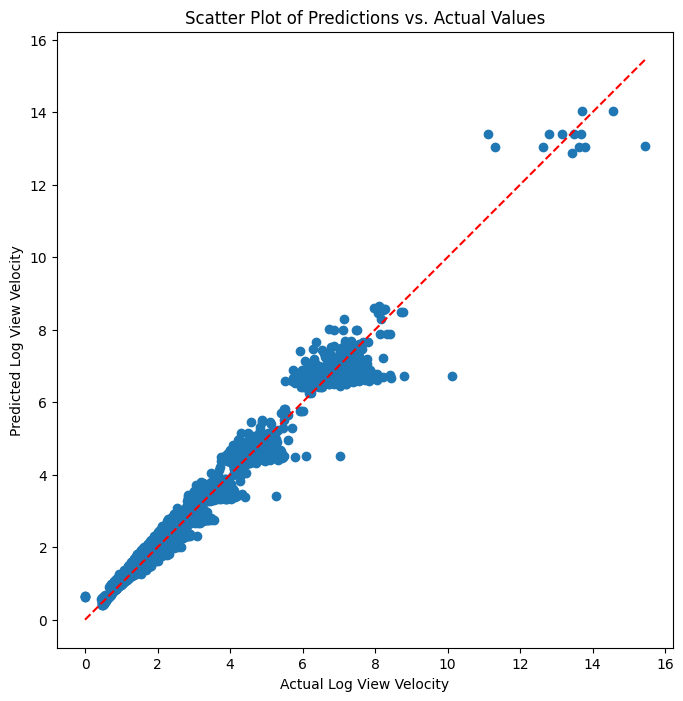

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


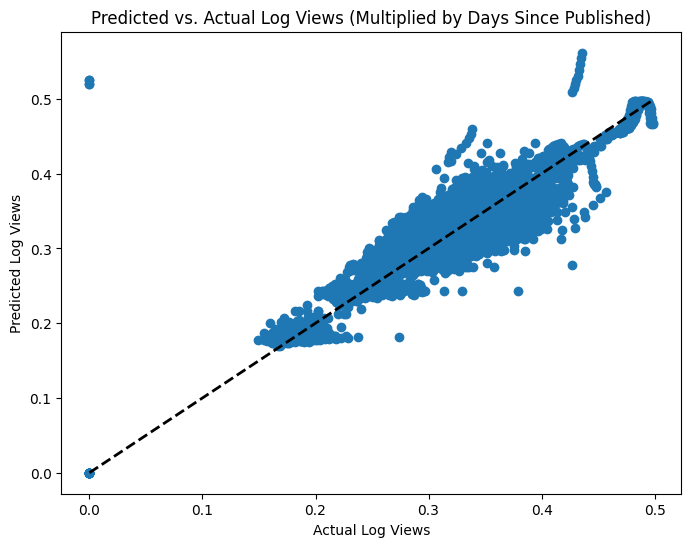

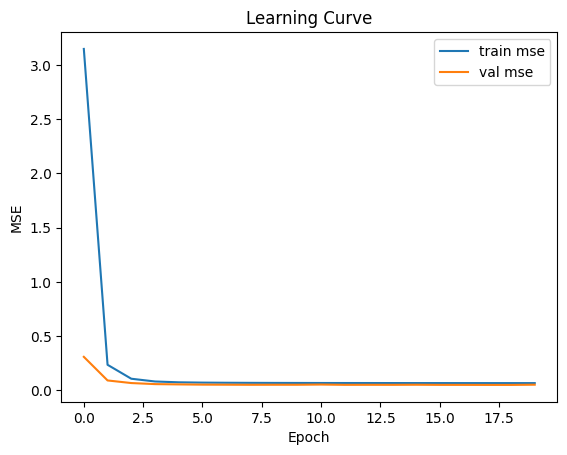

In [133]:
# Call the plot functions
plot_y_pred_test(model)
plot_log_views(model)
plot_learning_curve()

In [134]:
# same model just using adam optimizer

from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import BatchNormalization


model = keras.Sequential([
    keras.layers.Dense(256, activation='tanh', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1)
])
adam = Adam(learning_rate=0.00001)
# Compile the model with adjusted learning rate

model.compile(optimizer= adam, loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=42, validation_data=(X_validation, y_validation))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 4.2275 - mse: 4.2275 - val_loss: 0.2596 - val_mse: 0.2596
Epoch 2/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.3796 - mse: 0.3796 - val_loss: 0.0851 - val_mse: 0.0851
Epoch 3/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.2223 - mse: 0.2223 - val_loss: 0.0691 - val_mse: 0.0691
Epoch 4/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.1871 - mse: 0.1871 - val_loss: 0.0646 - val_mse: 0.0646
Epoch 5/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.1577 - mse: 0.1577 - val_loss: 0.0598 - val_mse: 0.0598
Epoch 6/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.1327 - mse: 0.1327 - val_loss: 0.0579 - val_mse: 0.0579
Epoch 7/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.1180 - mse: 0.1180 - val_loss: 0.0559 - val_mse: 0.0559
Epoch 8/20
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.0982 - mse: 0.0982 - val_loss: 0.0549 - val_mse: 0.0549
Epoch 9/20
5895/5895 ━━━━━━━━━━━

In [135]:
mse = model.evaluate(X_test, y_test)[1]
print(f"Test MSE: {mse}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0444 - mse: 0.0444
Test MSE: 0.046367812901735306


In [136]:
history.history['val_mse'][-1]

0.0506165586411953

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


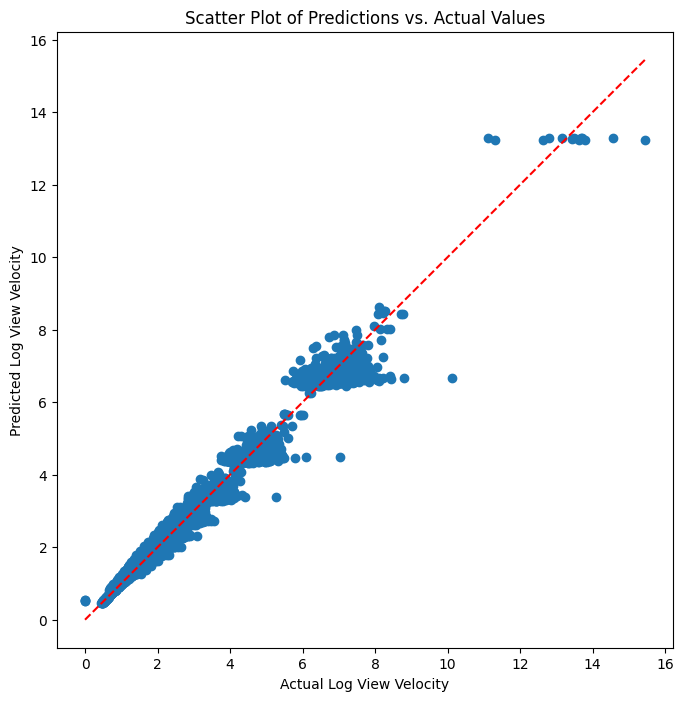

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


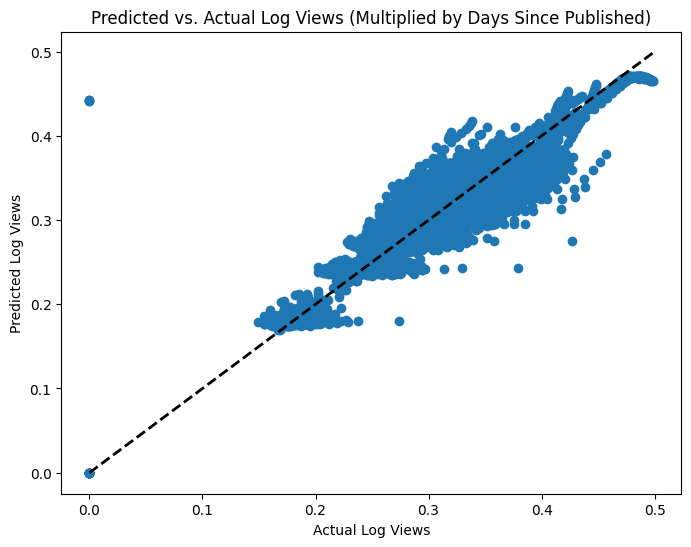

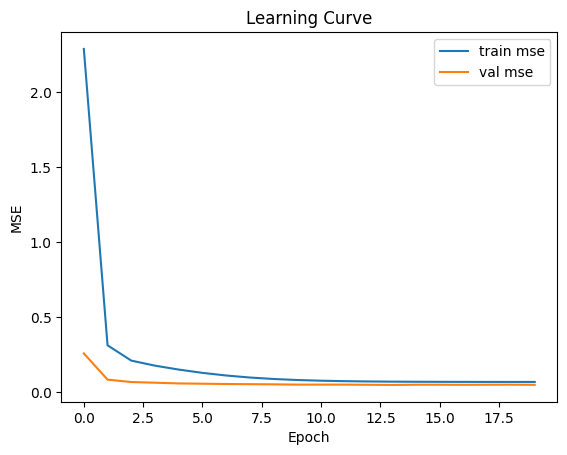

In [137]:
# Call the plot functions
plot_y_pred_test(model)
plot_log_views(model)
plot_learning_curve()

## Model with added numerical features and categorical features

In [ ]:
# prompt: use 2023 data to train, data from 2023 up to 2/18/2024 for validation and data from 2/18/2024 and on as test data.

# Assuming you have already loaded and preprocessed your data as in the provided code
# and model_df is your DataFrame with 'trending_date' and 'log_view_velocity'
features = ['days_since_published', 'square_of_days_since_published',
            'log_days_since_publication', 'sqrt_days_since_publication',
            'title_length', 'tags_count','description_length', 'top_20_tag_count']
features += list(encoded_weekday_df.columns) + list(encoded_category_df.columns) + list(encoded_channels_df.columns)

# Convert 'trending_date' to datetime objects if it's not already
model_df['trending_date'] = pd.to_datetime(model_df['trending_date'])

# Define the split dates
train_end_date = pd.to_datetime('2023-12-31')
validation_end_date = pd.to_datetime('2024-02-18')

# Create train, validation, and test datasets
train_df = model_df[(model_df['trending_date'] <= train_end_date)]
validation_df = model_df[(model_df['trending_date'] > train_end_date) & (model_df['trending_date'] <= validation_end_date)]
test_df = model_df[(model_df['trending_date'] > validation_end_date)]

# Separate features and target variable for train, validation, and test sets
X_train = train_df[features]
y_train = train_df['log_view_velocity']
X_validation = validation_df[features]
y_validation = validation_df['log_view_velocity']
X_test = test_df[features]
y_test = test_df['log_view_velocity']


In [ ]:
#from keras.optimizers import SGD

# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])
# Adjust learning rate
learning_rate = 0.001  # You can experiment with different values

# Compile the model with adjusted learning rate
# optimizer = SGD(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_validation, y_validation))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.6379 - mse: 0.6379 - val_loss: 0.0577 - val_mse: 0.0577
Epoch 2/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0754 - mse: 0.0754 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 3/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0718 - mse: 0.0718 - val_loss: 0.0525 - val_mse: 0.0525
Epoch 4/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0692 - mse: 0.0692 - val_loss: 0.0607 - val_mse: 0.0607
Epoch 5/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0707 - mse: 0.0707 - val_loss: 0.0616 - val_mse: 0.0616
Epoch 6/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0668 - mse: 0.0668 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 7/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0720 - mse: 0.0720 - val_loss: 0.0526 - val_mse: 0.0526
Epoch 8/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0692 - mse: 0.0692 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 9/20
7738/7738 ━━━━━━━━━━━

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


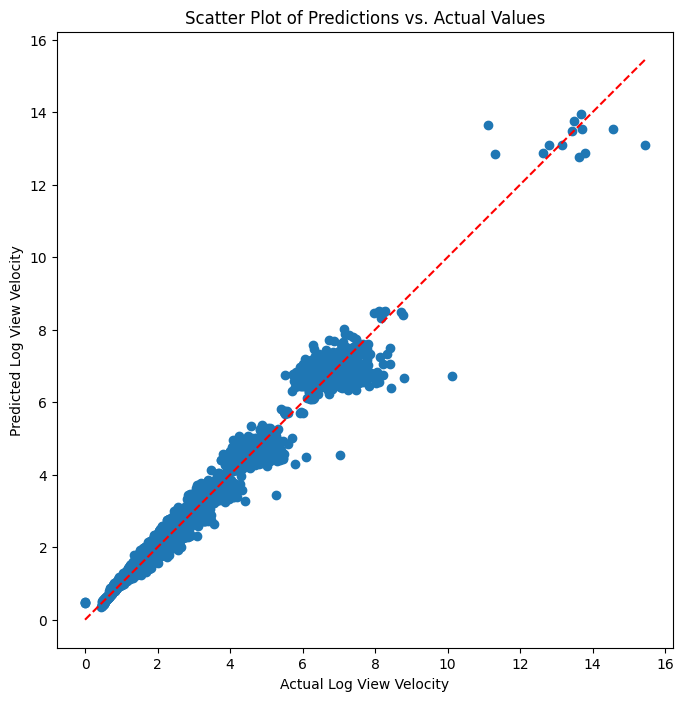

In [ ]:
# prompt: Scatter Plot of Predictions vs Actual Values. show both axis proportionally with a diagonal line


plot_y_pred_test(model)

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


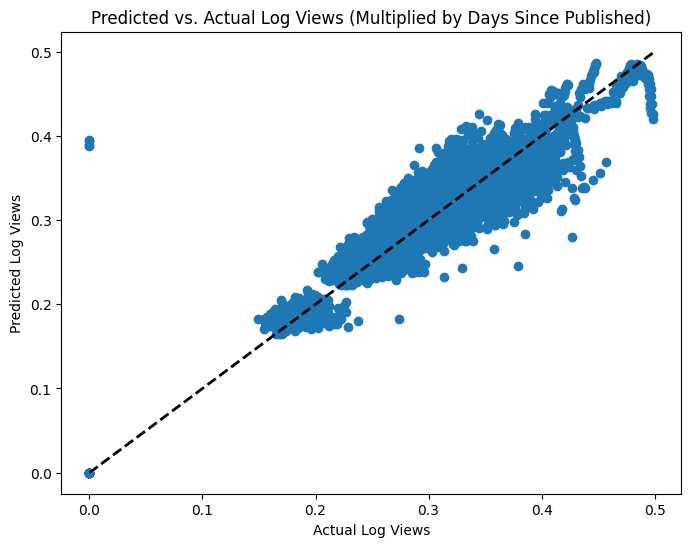

In [ ]:

plot_log_views(model)


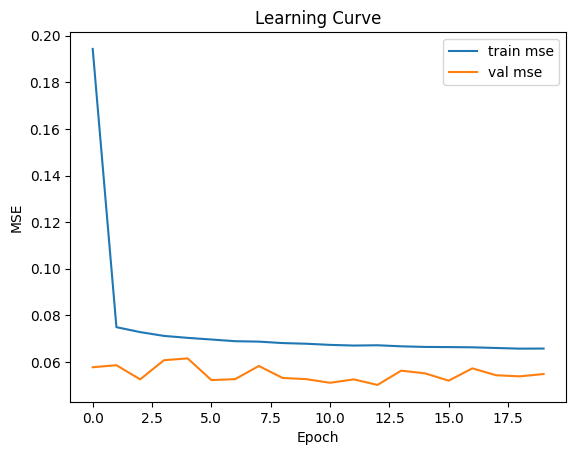

In [ ]:
# prompt: plot the learning curve of this model. plot train loss and val loss mse

plot_learning_curve()

## Model with numerical & categorical and hashed (channels) features

In [ ]:
features = ['days_since_published', 'square_of_days_since_published',
            'log_days_since_publication', 'sqrt_days_since_publication']
features += list(hashed_features_df.columns) + list(encoded_weekday_df.columns) + list(encoded_category_df.columns)

# Convert 'trending_date' to datetime objects if it's not already
model_df['trending_date'] = pd.to_datetime(model_df['trending_date'])

# Define the split dates
train_end_date = pd.to_datetime('2023-12-31')
validation_end_date = pd.to_datetime('2024-02-18')

# Create train, validation, and test datasets
train_df = model_df[(model_df['trending_date'] <= train_end_date)]
validation_df = model_df[(model_df['trending_date'] > train_end_date) & (model_df['trending_date'] <= validation_end_date)]
test_df = model_df[(model_df['trending_date'] > validation_end_date)]

# Separate features and target variable for train, validation, and test sets
X_train = train_df[features]
y_train = train_df['log_view_velocity']
X_validation = validation_df[features]
y_validation = validation_df['log_view_velocity']
X_test = test_df[features]
y_test = test_df['log_view_velocity']

In [ ]:

# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

# Adjust learning rate
learning_rate = 0.001  # You can experiment with different values

# Compile the model with adjusted learning rate
optimizer = SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_validation, y_validation))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 2.4160 - mse: 2.4160 - val_loss: 0.0974 - val_mse: 0.0974
Epoch 2/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.1423 - mse: 0.1423 - val_loss: 0.0810 - val_mse: 0.0810
Epoch 3/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.1095 - mse: 0.1095 - val_loss: 0.0720 - val_mse: 0.0720
Epoch 4/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0956 - mse: 0.0956 - val_loss: 0.0747 - val_mse: 0.0747
Epoch 5/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0898 - mse: 0.0898 - val_loss: 0.0659 - val_mse: 0.0659
Epoch 6/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0839 - mse: 0.0839 - val_loss: 0.0644 - val_mse: 0.0644
Epoch 7/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0790 - mse: 0.0790 - val_loss: 0.0616 - val_mse: 0.0616
Epoch 8/20
7738/7738 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0792 - mse: 0.0792 - val_loss: 0.0622 - val_mse: 0.0622
Epoch 9/20
7738/7738 ━━━━━━━━━━━

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


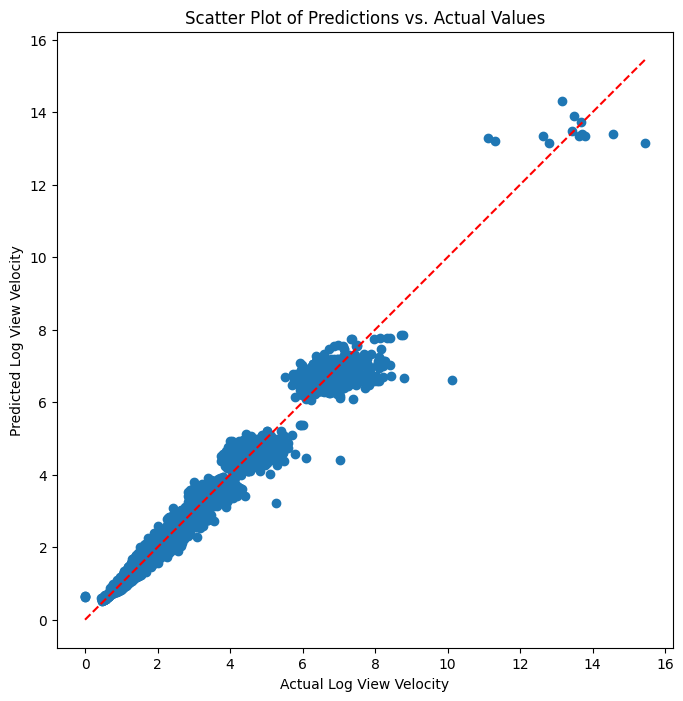

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


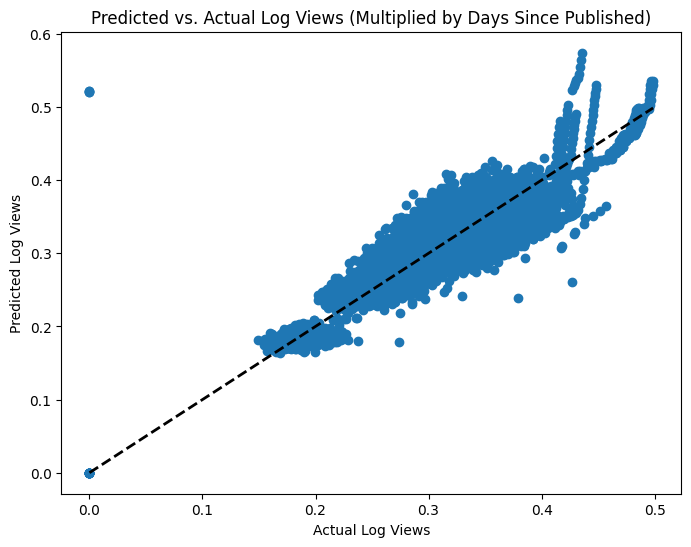

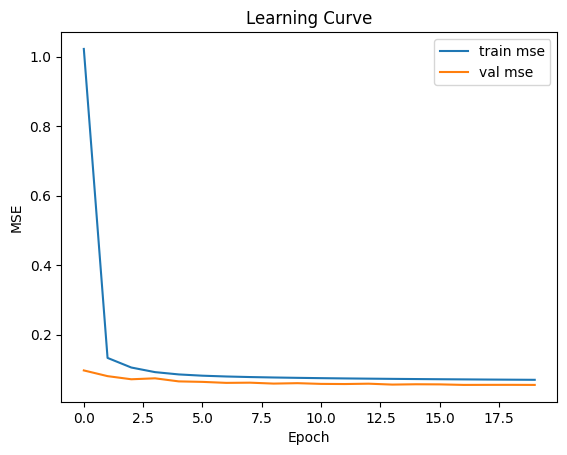

In [ ]:

# Call the plot functions
plot_y_pred_test(model)
plot_log_views(model)
plot_learning_curve()